This takes an input dem and creates a subset of it suifficient for the Mason Sykes (MS) routine in DBSM. This subset needs to be a square extent of size power of 2.

Change compiler to be your compiler of choice (e.g., gfortran)

After creating the DEM and a zero-height vegetation DSM, this creates the required include file for the DBSM code and builds a correct copy of DBSM.

On output, this creates 8 files named
Windspeed_Normalized_1.asc
to
Windspeed_Normalized_8.asc

The _[1-8] corresponds to the dd values in DBSM. These asc files can be used to parameterize CHM for the MS_wind model.

parameter_files = {
					'MS1' : {'file':'Windspeed_Normalized_1.asc','method':'mean'},
					'MS2' : {'file':'Windspeed_Normalized_2.asc','method':'mean'},
					'MS3' : {'file':'Windspeed_Normalized_3.asc','method':'mean'},
					'MS4' : {'file':'Windspeed_Normalized_4.asc','method':'mean'},
					'MS5' : {'file':'Windspeed_Normalized_5.asc','method':'mean'},
					'MS6' : {'file':'Windspeed_Normalized_6.asc','method':'mean'},
					'MS7' : {'file':'Windspeed_Normalized_7.asc','method':'mean'},
					'MS8' : {'file':'Windspeed_Normalized_8.asc','method':'mean'},
				}

In [24]:
get_ipython().magic('matplotlib inline')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from osgeo import gdal,osr
import os

In [2]:
def read_column_to_2d(filein,dxdy):
    df = pd.read_csv(filein,delimiter ='\t',header=None,engine='python')
    df2 = pd.DataFrame(df[0].values.reshape(dxdy,dxdy))
    return df2


In [3]:
#full path doesn't seem to work, needs to be in the same dir
dem = 'Fortress_2m_DEM1.tif'  

#pixel coordinate offset to start at
offx = 0
offy = 0

#must be power of 2
size = 2048
compiler = 'ifort'


#build up the power of 2 dem as a subset of the maindem
outdem = dem + '_MS.asc'
cmd = 'gdal_translate -srcwin %i %i %i %i -of AAIGrid %s %s' % \
       (offx, offy, size, size, dem, outdem)
subprocess.check_output(cmd, shell=True)

outdem_veg = dem + '_MS_veg.asc'
cmd = 'gdal_translate -srcwin %i %i %i %i -scale 0 999999 0 0 -of AAIGrid %s %s' % \
       (offx, offy, size, size, dem, outdem_veg)
subprocess.check_output(cmd, shell=True)

ds = gdal.Open(dem)
dxdy = ds.GetGeoTransform()[1] ##assume square pixels

#hyper sensitivity to this formating...don't add a space infront of the two &
param = "\t\tparameter ( \n\
     &            n = %i   \n\
     &,           dt = 1800. \n \
    &,           dx = %i \n\
     &,           nsteps = 1 \n\
     &,           sx = 206 \n\
     &,           sy = 171 \n\
     &,           met_file = 'tvc_9697_met.txt' \n \
    &,           topo_file = '%s'     \n\
     &,           veg_file = '%s'   \n\
     &          )\n" \
%(size,dxdy,outdem,outdem_veg)

with open('site_params.inc', "w") as text_file:
    text_file.write(param)

cmd = '%s dbsm.f -O3 -o dbsm' % (compiler)
subprocess.check_output(cmd, shell=True)
    
rasterinfo =  ''
with open(outdem) as f:
    rasterinfo = [next(f) for x in xrange(6)]

#remove the ascii header
# lines = open(outdem).readlines()
# open(outdem, 'w').writelines(lines[6:])

# lines = open(outdem_veg).readlines()
# open(outdem_veg, 'w').writelines(lines[6:])

In [4]:
subprocess.check_output('./dbsm', shell=True)

''

In [5]:
dem_file = r'DEMsmooth.txt'
df_dem = read_column_to_2d(dem_file,size)

In [25]:
srs = osr.SpatialReference()
wkt = ds.GetProjection()
srs.ImportFromWkt(wkt)
proj4 = srs.ExportToProj4()

for i in range(1,9): #match fortran's number
    WS_file = 'Windspeed_Normalized_'+str(i)+'.txt'
    windout = 'Windspeed_Normalized_'+str(i)+'.asc'
    windout_tif = 'Windspeed_Normalized_'+str(i)+'.tif'
    df_WS = read_column_to_2d(WS_file,size)
    
    df_WS.to_csv(windout,sep=' ',header=False,index=False)
    
    lines = open(windout).readlines()
    
    with open(windout,'w') as file:
        file.writelines(rasterinfo)
        file.writelines(lines)
    
    # we can apply a projection to the asc files, which end up as .aux.xml files. However neither 
    # GDAL or Arc seems to read these files. So if we convert it to a tif, we can then embed the projection
    # into the file and everything works
    #convert the asc to tif
    cmd = 'gdalwarp -overwrite \'%s\' \'%s\'' % (windout,windout_tif)
    subprocess.check_output(cmd, shell=True)
    
    #set the project
    cmd = 'gdal_edit.py -a_srs \'%s\' \'%s\'' % (proj4,windout_tif)
    subprocess.check_output(cmd, shell=True)

    os.remove(windout)


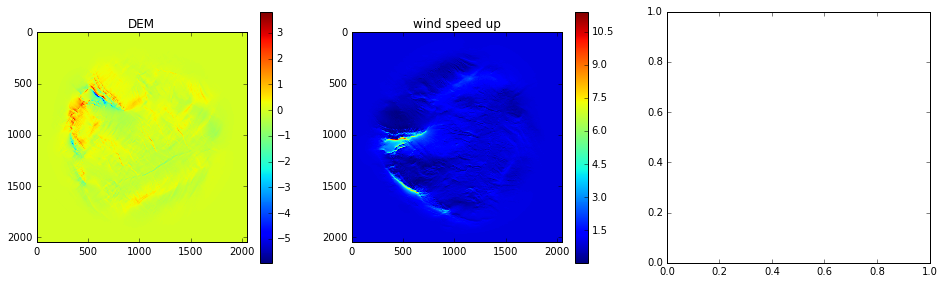

In [7]:
f1, (ax1,ax2,ax3) = plt.subplots(ncols=3)
f1.set_size_inches(16, 4.5)

p1 = ax1.imshow(df_dem)
f1.colorbar(p1, ax=ax1)
ax1.set_title('DEM')

p2 = ax2.imshow(df_WS)
f1.colorbar(p2, ax=ax2)
ax2.set_title('wind speed up')